In [1]:
# !pip install numpy==1.19.5
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')

[]

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Wheat Disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2942 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']

In [6]:
len(dataset)

92

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 2 1 2 0 2 2 2 1 0 2 1 0 1 2 2 1 0 2 1 1 0 2 2 1 1 0 1 1]


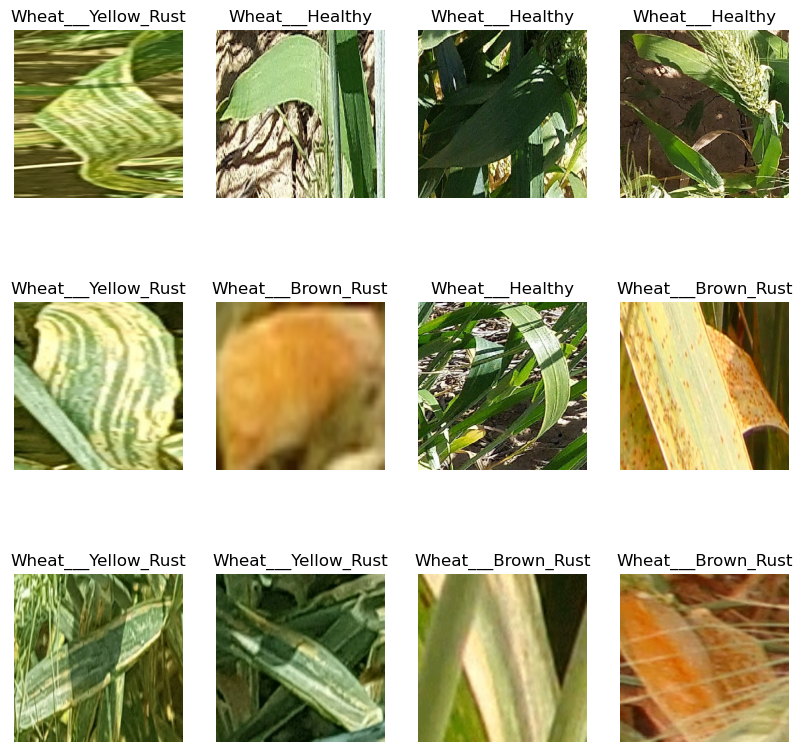

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

73.60000000000001

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

73

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])


In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 612ms/step - accuracy: 0.5132 - loss: 0.8716 - val_accuracy: 0.6493 - val_loss: 0.5756
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.7068 - loss: 0.5382 - val_accuracy: 0.8438 - val_loss: 0.4292
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 0.8479 - loss: 0.3826 - val_accuracy: 0.8542 - val_loss: 0.4748
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 529ms/step - accuracy: 0.8812 - loss: 0.3141 - val_accuracy: 0.9340 - val_loss: 0.1656
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 547ms/step - accuracy: 0.9038 - loss: 0.2336 - val_accuracy: 0.9271 - val_loss: 0.2245
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 569ms/step - accuracy: 0.9344 - loss: 0.2094 - val_accuracy: 0.9167 - val_loss: 0.2191
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 562ms/step - accuracy: 0.9320 - loss: 0.1823 - val_accuracy: 0.9549 - val_loss: 0.1239
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 559ms/step - accuracy: 0.9470 - loss: 0.1576 - val_accu

In [21]:
scores = model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9973 - loss: 0.0163


In [22]:
scores

[0.02088954485952854, 0.996874988079071]

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [25]:
# plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        # ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        # plt.axis("off")
        print(f"actual_class {actual_class}, predicted_class {predicted_class}, confidence {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
actual_class Wheat___Healthy, predicted_class Wheat___Healthy, confidence 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
actual_class Wheat___Yellow_Rust, predicted_class Wheat___Yellow_Rust, confidence 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
actual_class Wheat___Brown_Rust, predicted_class Wheat___Brown_Rust, confidence 99.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
actual_class Wheat___Healthy, predicted_class Wheat___Healthy, confidence 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
actual_class Wheat___Yellow_Rust, predicted_class Wheat___Yellow_Rust, confidence 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
actual_class Wheat___Yellow_Rust, predicted_class Wheat___Yellow_Rust, confidence 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
actual_class Wheat___Healthy, predicted_class Wheat___Healthy, confidence 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
actual_class Wheat___Healthy, predicted_class Wheat___Healthy, confidence 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [27]:
model.save("./wheat.h5")